In [1]:
import joblib 
import numpy as np 
from matplotlib import pyplot as plt 
from uncertainties import ufloat, unumpy

from pathlib import Path
from tqdm import tqdm
from numpy import array
from core.utils import *
import atlas_mpl_style as ampl


pkl_path = '/global/cfs/projectdirs/atlas/wys/HEP_Repo/QG_Calibration/NewWorkflow/note_plots'
pkl_path = Path(pkl_path)
nominal_path = pkl_path / 'nominal' / 'plots' / 'ADE' / 'Extraction_Results'


nominal_SFs = joblib.load(nominal_path / "none_Extraction_Results.pkl") 

label_pt_bin=[500,600,800,1000,1200,1500,2000]

bin_centers = 0.5 * (np.array(label_pt_bin[:-1]) + np.array(label_pt_bin[1:]))

In [23]:
nominal_SFs['jet_nTracks'][500]['p_Quark']

array([0.0+/-0, 0.0+/-0, 0.0012592558735659018+/-1.0815094524812982e-05,
       0.003516229877759722+/-1.819495085831079e-05,
       0.008113378068709353+/-2.7721812368339523e-05,
       0.015666248168006113+/-3.850848364298517e-05,
       0.02596232421067722+/-4.94918865417252e-05,
       0.03776805406548431+/-5.9612721200700544e-05,
       0.049469474033363596+/-6.820881119571696e-05,
       0.05915497541618699+/-7.461434796068747e-05,
       0.06604434161277188+/-7.878123712947181e-05,
       0.06924979329227718+/-8.048627382205948e-05,
       0.06940413541978653+/-8.048406796752115e-05,
       0.06744965851763671+/-7.929987392999378e-05,
       0.06351294765825044+/-7.686611206937345e-05,
       0.058844405951151015+/-7.395213498871243e-05,
       0.05369841072941142+/-7.068385710580284e-05,
       0.0484137607835778+/-6.707291048574463e-05,
       0.04319151120745935+/-6.336024442923833e-05,
       0.03826593061365204+/-5.9615506581069876e-05,
       0.033650200721719856+/-5.59692

In [2]:
def safe_array_divide_unumpy(numerator, denominator):
    if 0 in unumpy.nominal_values(denominator):
        _denominator_nominal_values = unumpy.nominal_values(denominator)
        _denominator_std_devs = unumpy.std_devs(denominator)
        zero_idx = np.where(_denominator_nominal_values==0)[0]
        _denominator_nominal_values[zero_idx] = np.inf
        _denominator_std_devs[zero_idx] = 0 
        _denominator = unumpy.uarray(_denominator_nominal_values, _denominator_std_devs)

        ratio = np.true_divide(numerator, _denominator) 
        # raise Warning(f"0 exists in the denominator for unumpy, check it!")
    else:
        ratio = np.true_divide(numerator, denominator)        
    return ratio

In [3]:
HistBins={
   "jet_nTracks": np.linspace(0, 60, 61),
   'GBDT_newScore' : np.linspace(-5.0, 5.0, 101),
}

Map_var_title = {
    "jet_pt": "$p_{T}$",
    "jet_nTracks": "$N_{trk}$",
    "jet_trackBDT": "old BDT",
    "jet_eta": "$\eta$",
    "jet_trackC1": "$C_{1}$",
    "jet_trackWidth": "W",
    "GBDT_newScore": "BDT"
}



/tmp/ipykernel_255834/870205928.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1], 'hspace': 0.1})


KeyError: 2000

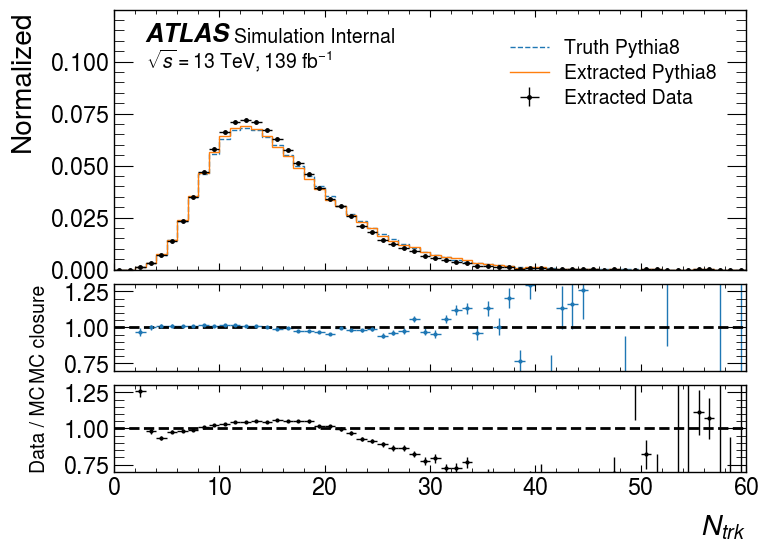

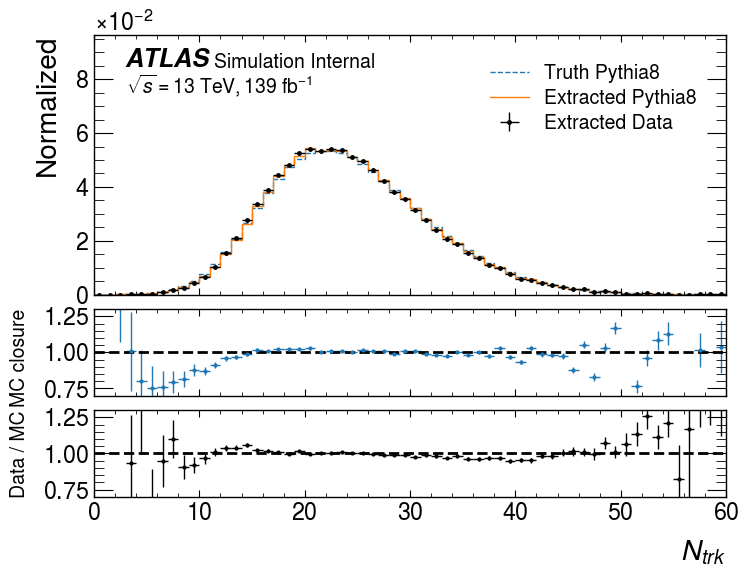

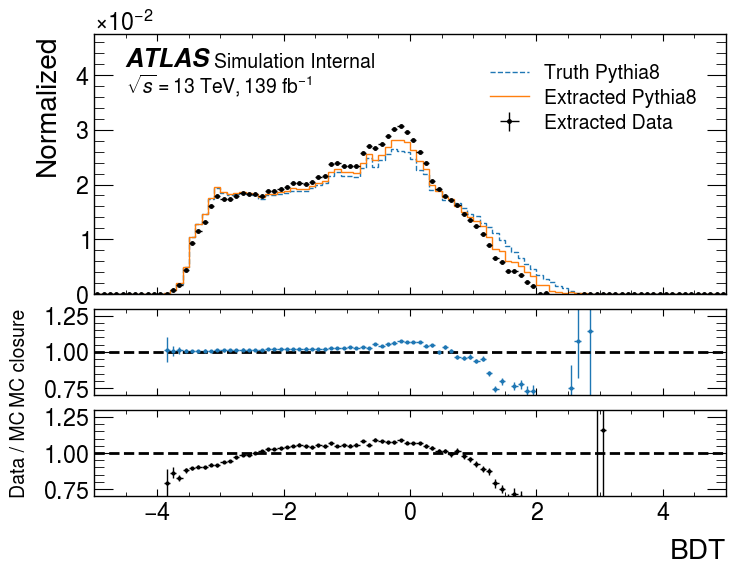

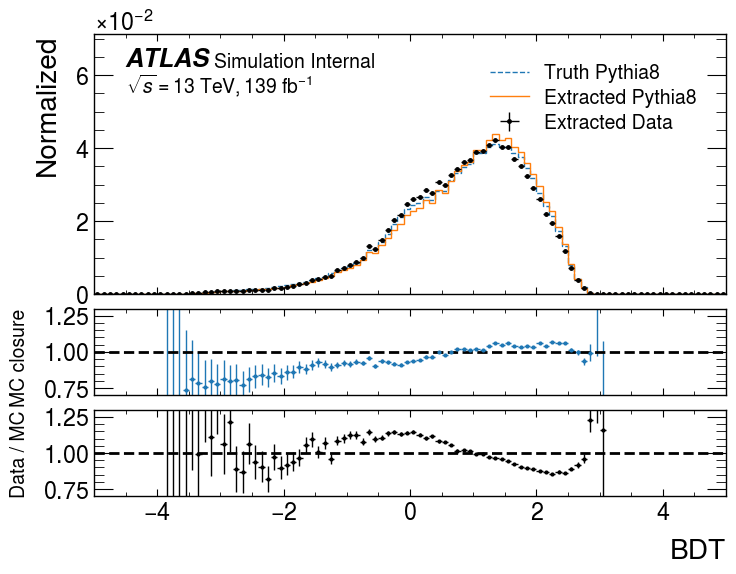

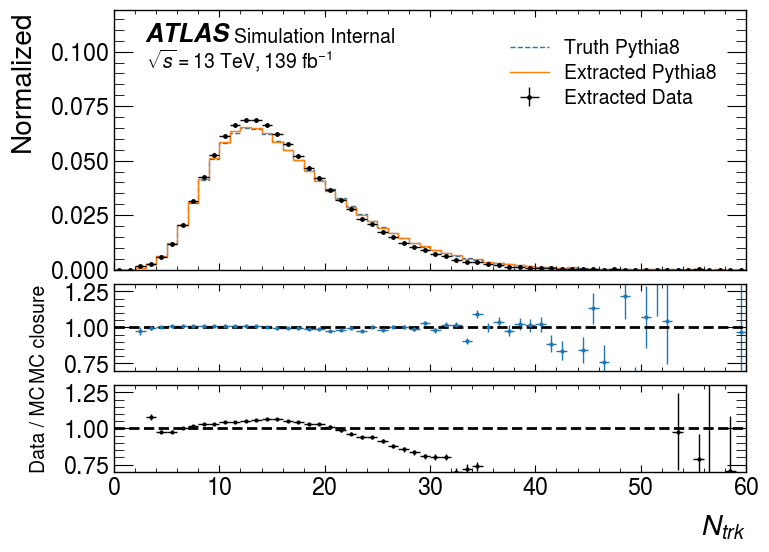

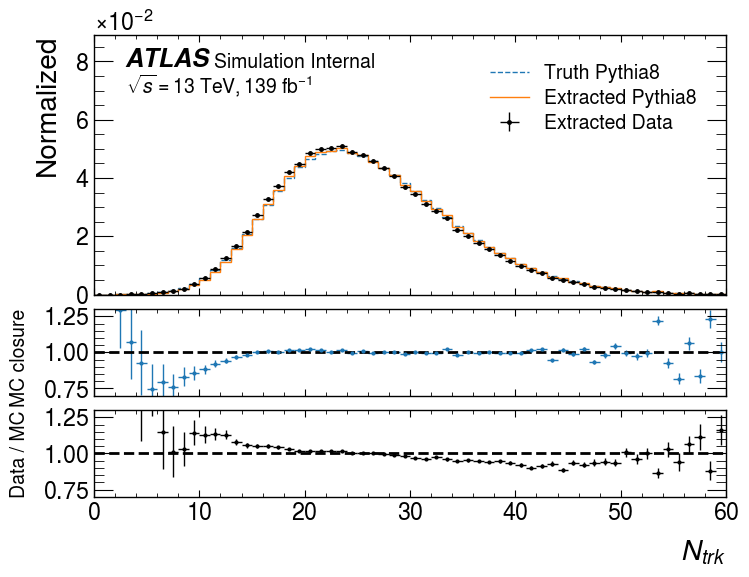

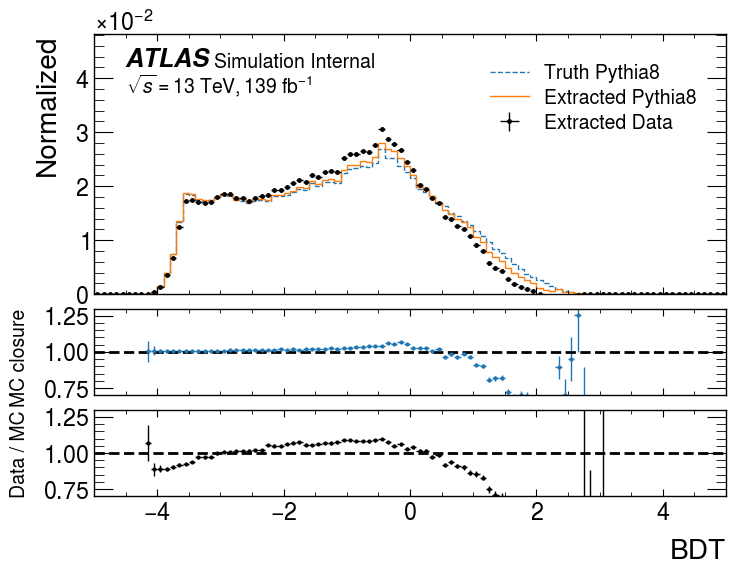

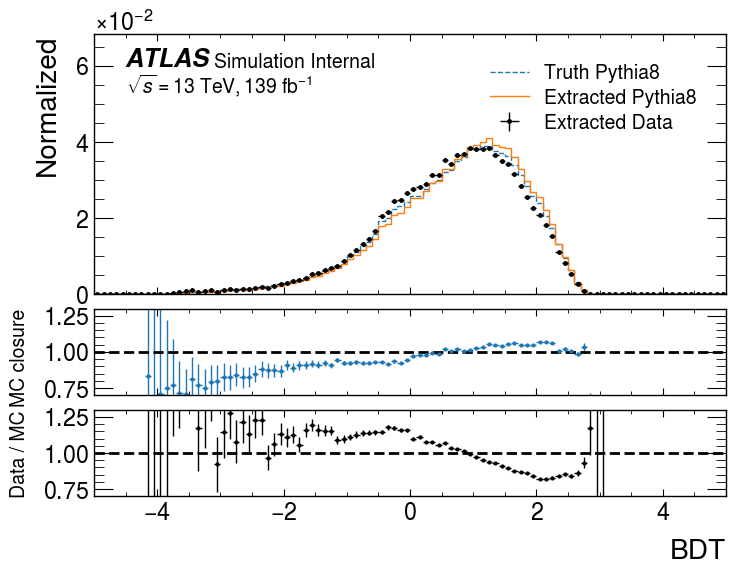

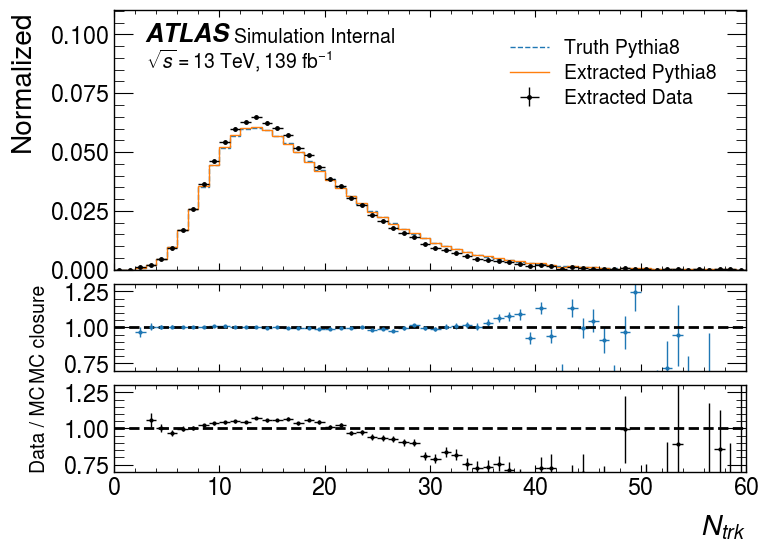

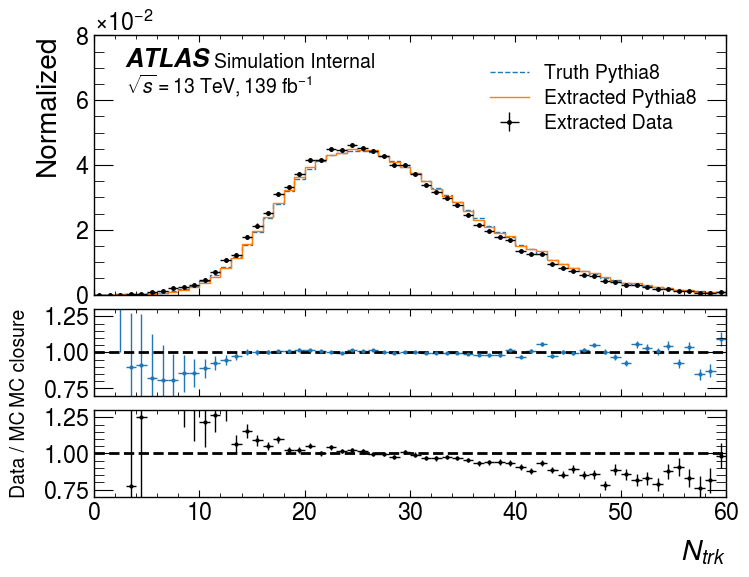

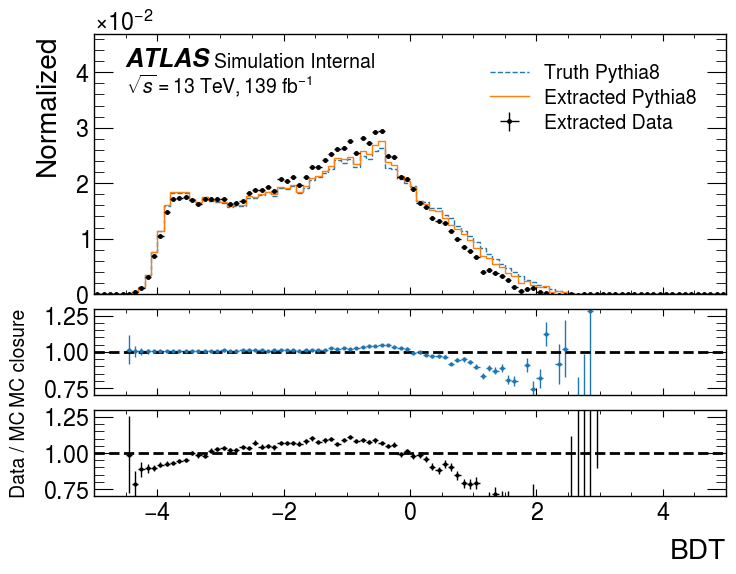

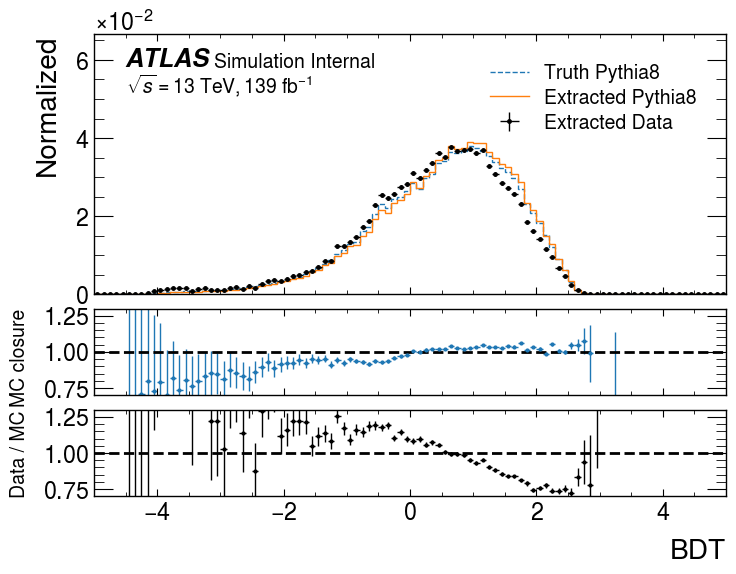

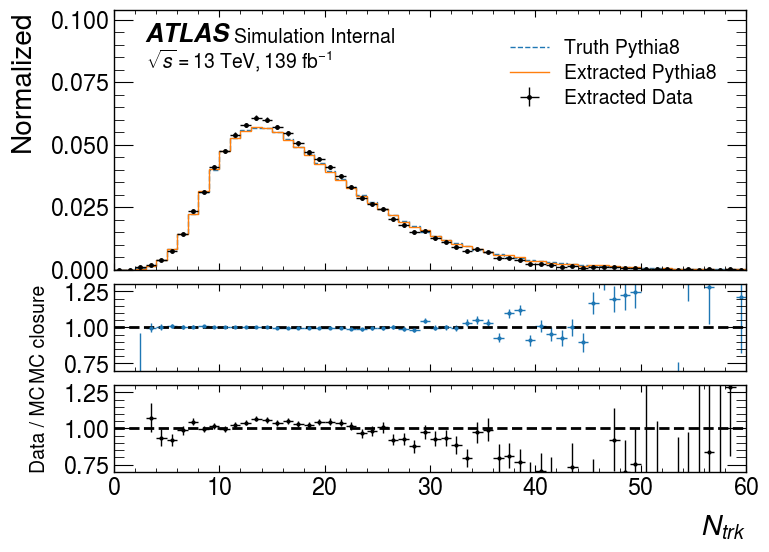

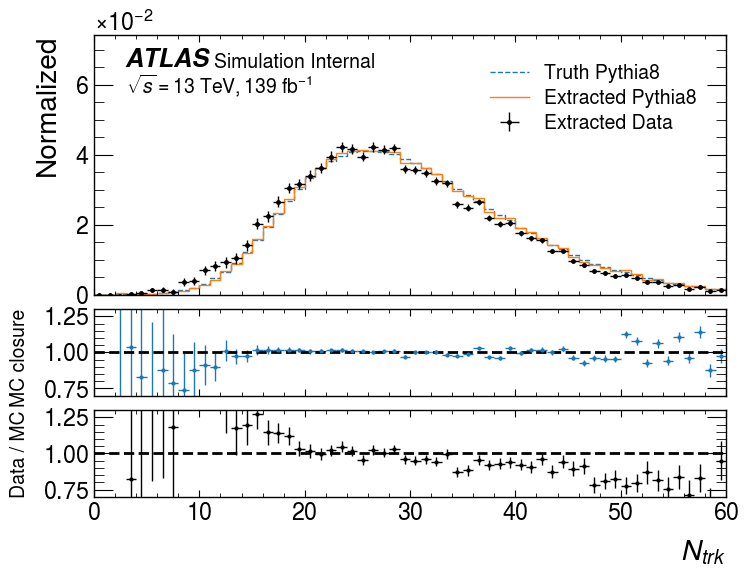

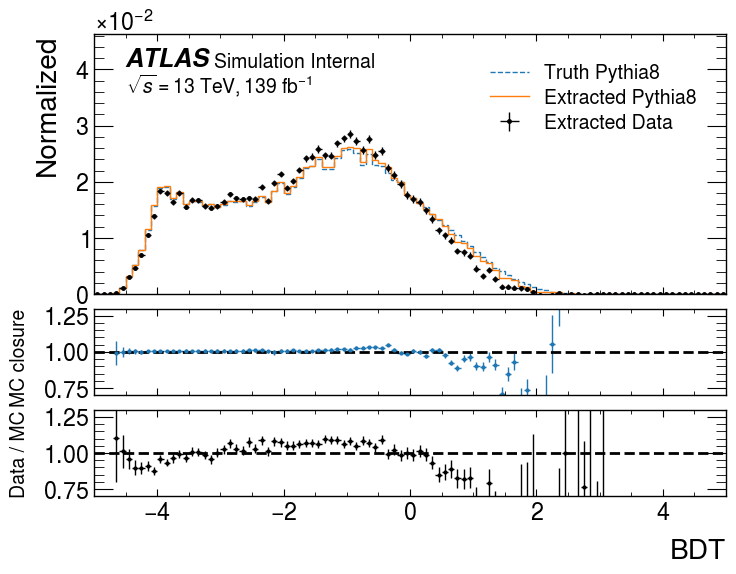

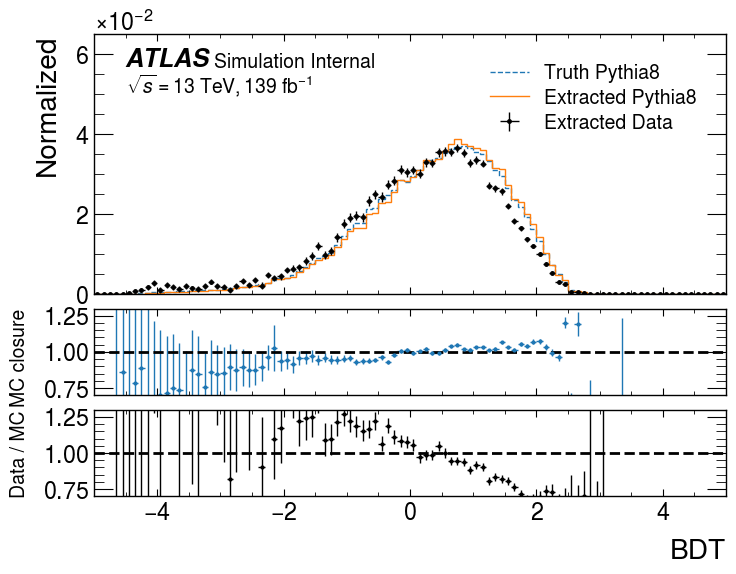

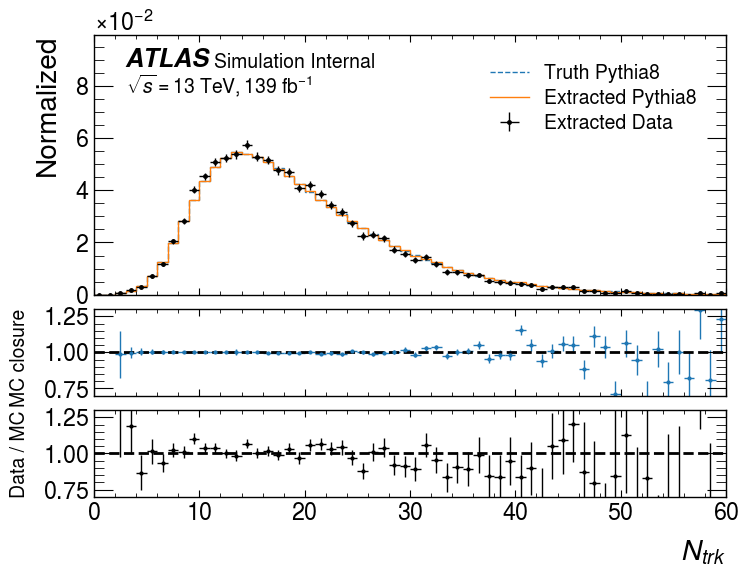

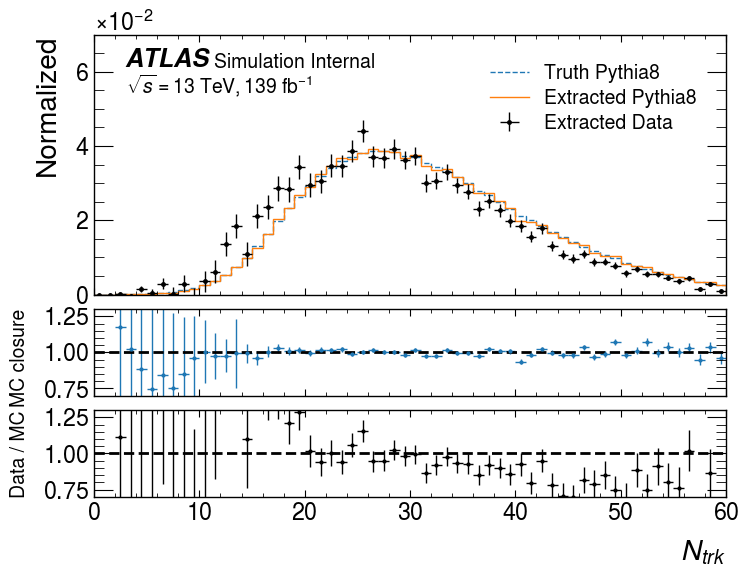

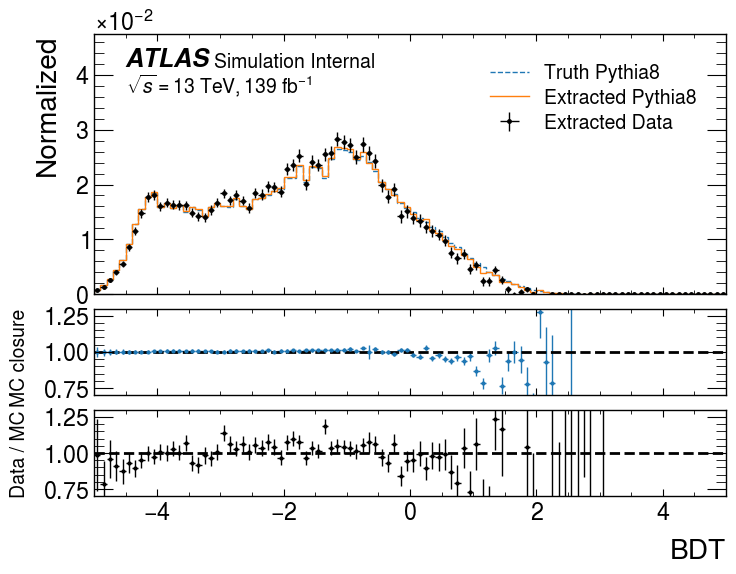

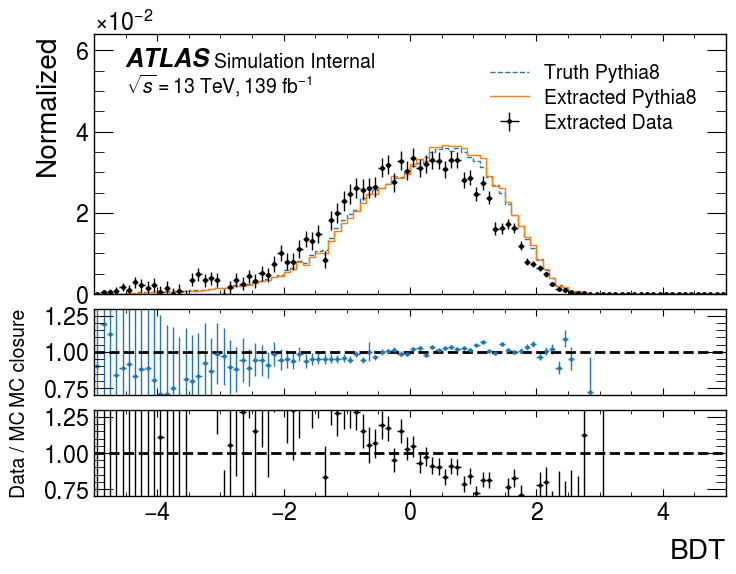

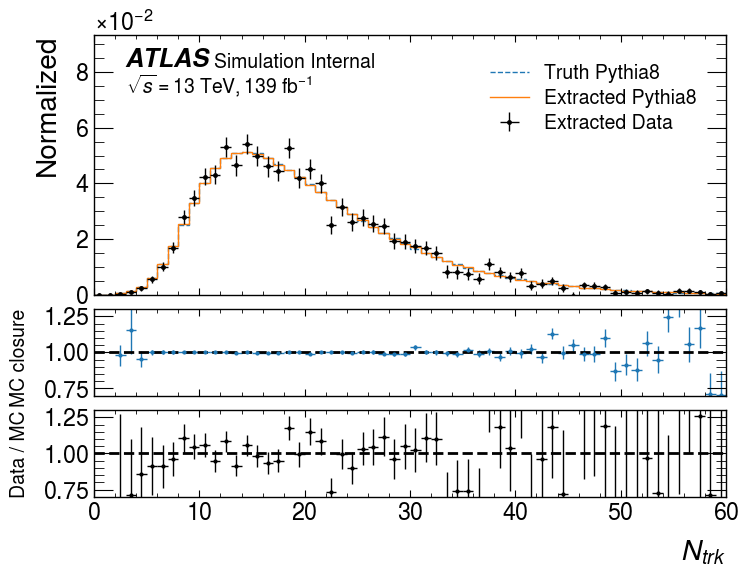

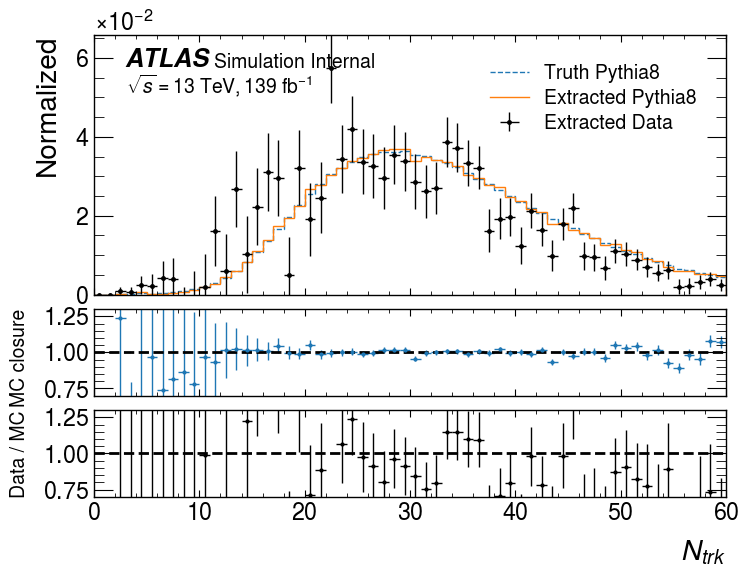

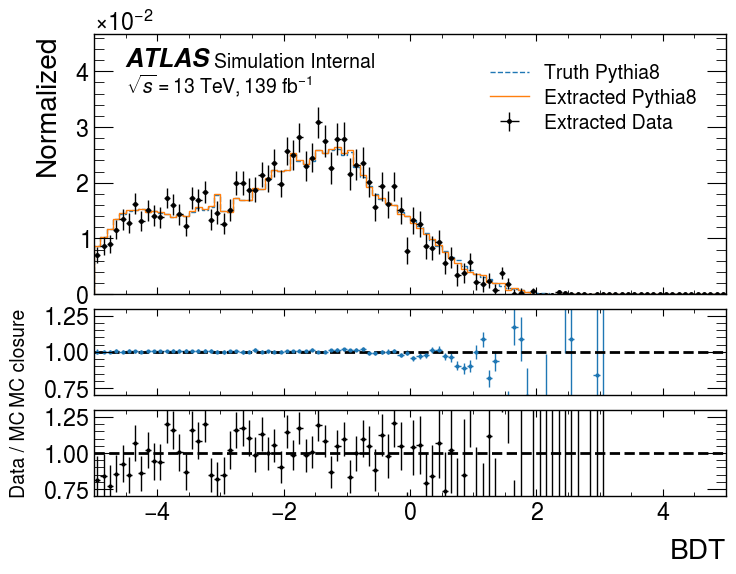

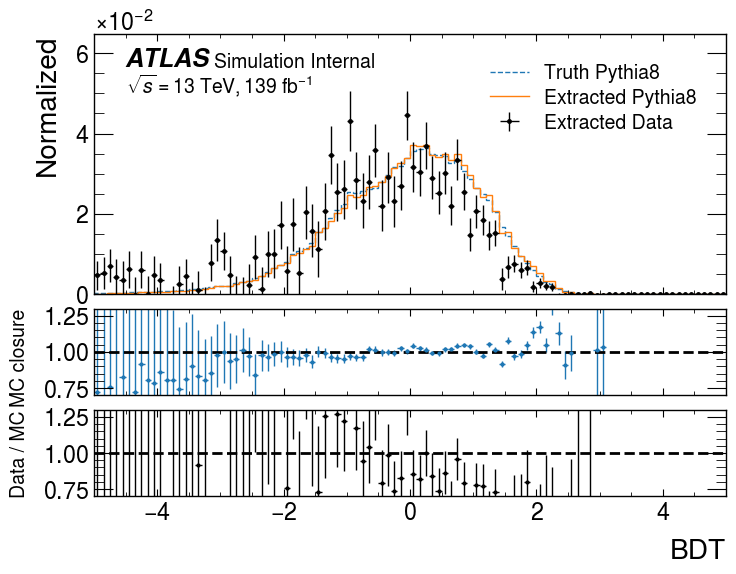

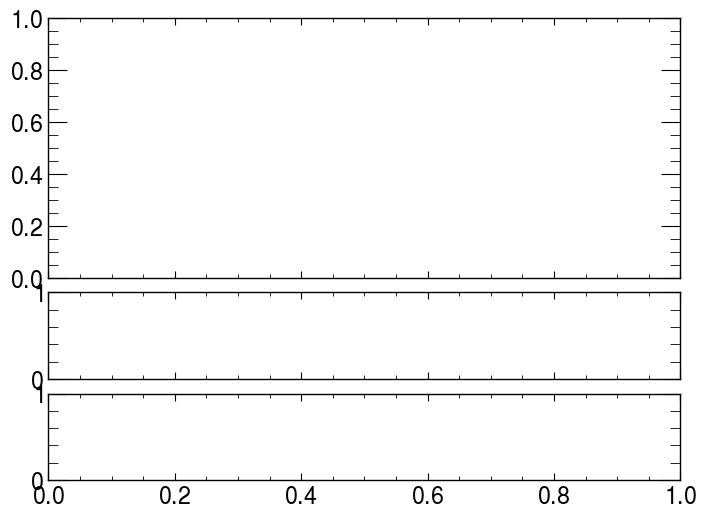

In [26]:
#ampl.use_atlas_style()

import mplhep as hep
hep.style.use("ATLAS")
#hep.ATLAS.label("Internal", data=False, lumi=50, year=2017)


for pt in label_pt_bin:
    for rew in ['jet_nTracks','GBDT_newScore']:
        bin_edges = HistBins[rew]
        bin_centers1 = 1/2 * (bin_edges[:-1] + bin_edges[1:])
        ntrk = joblib.load(nominal_path / f"{rew}_Extraction_Results.pkl")


        for parton in ['Quark','Gluon']:

            fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1], 'hspace': 0.1})
            nom_truth = nominal_SFs[rew][pt][f'p_{parton}']
            ntrk_truth = ntrk[rew][pt][f'p_{parton}']        

            nom_Q = nominal_SFs[rew][pt][f'extract_p_{parton}_MC']
            ntrk_Q = ntrk[rew][pt][f'extract_p_{parton}_MC']
            ntrk_data = ntrk[rew][pt][f'extract_p_{parton}_Data']


            #ax0.errorbar(x = bin_centers1, y =unumpy.nominal_values(nom_truth), yerr =unumpy.std_devs(nom_truth),drawstyle = 'steps-mid',label = "Truth MC (before)",color="blue")
            #ax0.errorbar(x = bin_centers1, y =unumpy.nominal_values(nom_Q), yerr =unumpy.std_devs(nom_Q),drawstyle = 'steps-mid',label = "Extracted MC (before)",color="blue",linestyle = '--')

            #ax0.errorbar(x = bin_centers1, y =unumpy.nominal_values(ntrk_truth), yerr =unumpy.std_devs(ntrk_truth),drawstyle = 'steps-mid',label = "Truth MC (after)",color="red")
            #ampl.plot.plot_1d("test",bin_edges,unumpy.nominal_values(ntrk_truth),stat_errs=unumpy.std_devs(ntrk_truth))
            #ax0.errorbar(x = bin_centers1, y =unumpy.nominal_values(ntrk_Q), yerr =unumpy.std_devs(ntrk_Q),drawstyle = 'steps-mid',label = "Extracted MC (after)",color="red",linestyle = '--')

            y_max = np.max(unumpy.nominal_values(nom_truth))
            hep.histplot(unumpy.nominal_values(ntrk_truth),bins=bin_edges,label='Truth Pythia8',ax=ax0,histtype='step',linestyle='--')
            hep.histplot(unumpy.nominal_values(ntrk_Q),bins=bin_edges,label='Extracted Pythia8',ax=ax0,histtype='step',linestyle='-')
            hep.histplot(unumpy.nominal_values(ntrk_data),bins=bin_edges,label='Extracted Data',ax=ax0,histtype='errorbar',marker=".",color='black',yerr=unumpy.std_devs(ntrk_data),xerr=True,markersize=5)


        
            ax0.set_ylim(0, y_max * 1.8)
            ax0.set_ylabel("Normalized")
            #ax0.set_title(f"{rew}_{parton}")
            #if rew =='GBDT_newScore' and parton == 'Gluon':
                #hep.atlas.label(label='Internal',ax=ax0,lumi=139)
                 #ampl.plot.draw_atlas_label(0.05, 0.6, ax=ax0, energy="13 TeV",lumi=139,simulation=True) 
            #else:
            hep.atlas.label(label='Internal',ax=ax0,lumi=139)

            ratio_truthMC_over_extractedMC = safe_array_divide_unumpy(ntrk_data,ntrk_Q)
            #ax1.errorbar(x = bin_centers1,y = unumpy.nominal_values(ratio_truthMC_over_extractedMC), yerr = unumpy.std_devs(ratio_truthMC_over_extractedMC), drawstyle = 'steps-mid',label="before",color="blue")

            ratio_truthMC_over_extractedMC2 = safe_array_divide_unumpy(ntrk_Q,ntrk_truth)
            hep.histplot(unumpy.nominal_values(ratio_truthMC_over_extractedMC2),bins=bin_edges,ax=ax1,histtype='errorbar',marker=".",yerr=unumpy.std_devs(ratio_truthMC_over_extractedMC2),xerr=True,markersize=4)
            hep.histplot(unumpy.nominal_values(ratio_truthMC_over_extractedMC),bins=bin_edges,ax=ax2,histtype='errorbar',marker=".",color='black',yerr=unumpy.std_devs(ratio_truthMC_over_extractedMC),xerr=True,markersize=4)


            #ax1.errorbar(x = bin_centers1,y = unumpy.nominal_values(ratio_truthMC_over_extractedMC2), yerr = unumpy.std_devs(ratio_truthMC_over_extractedMC2), drawstyle = 'steps-mid',label="after",color="red")
            #fig2,ax2,ratio_ax2 = ampl.ratio_axes()

            #ampl.set_color_cycle(pal='ATLAS')
            #ampl.plot.plot_signal('truth mc',bin_edges,unumpy.nominal_values(ntrk_truth),ax=ax2)
            #ampl.plot.plot_1d('extracted mc',bin_edges,unumpy.nominal_values(ntrk_Q),ax=ax2)

            # ax2.set_ylim(0, y_max * 1.5)
            # ax2.set_ylabel("Normalized") 
            # #ax2.set_xlim(bin_edges[0], bin_edges[-1])
            # ampl.plot.plot_ratio(bin_edges,data=unumpy.nominal_values(ntrk_Q),data_errs=unumpy.std_devs(ntrk_Q),bkg=unumpy.nominal_values(ntrk_truth),bkg_errs=unumpy.std_devs(ntrk_truth),ratio_ax=ratio_ax2,plottype='raw')
            # ampl.plot.draw_atlas_label(0.1, 0.9, ax=ax2, energy="13 TeV",lumi=139,simulation=True)
            ax1.set_ylim(0.7,1.3)
            ax2.set_ylim(0.7,1.3)
            ax1.set_ylabel("MC closure",fontsize=14)
            ax2.set_ylabel("Data / MC",fontsize=14)
            ax0.legend(loc='upper right')

            #ax1.legend()
            # ampl.plot.draw_legend()
            # #ratio_ax2.set_ylabel("Extracted/Truth")
            ax2.set_xlim(bin_edges[0], bin_edges[-1])
            # ampl.plot.set_xlabel(f"{Map_var_title[rew]}")
            ax2.set_xlabel(f"{Map_var_title[rew]}")
            ax1.hlines(y = 1, xmin = bin_edges[0], xmax = bin_edges[-1], color = 'black', linestyle = '--')
            ax2.hlines(y = 1, xmin = bin_edges[0], xmax = bin_edges[-1], color = 'black', linestyle = '--')

            fig.savefig(f'./mcclosure/mcclosure_{rew}_{parton}_{pt}.pdf')

